# Natural-gradient Projection Runner

Lightweight notebook to refine StyleGAN2 inversions via the natural-gradient projector.

In [2]:
from pathlib import Path
import sys
import torch

PROJECT_ROOT = Path('/Users/adamsobieszek/PycharmProjects/_manipy')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
DEIXIS_ROOT = PROJECT_ROOT / 'deixis'
for extra in [
    DEIXIS_ROOT,
    DEIXIS_ROOT / 'pixel2style2pixel',
    DEIXIS_ROOT / 'face_utils',
]:
    path_str = str(extra)
    if path_str not in sys.path:
        sys.path.append(path_str)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='mps')

In [3]:
import pickle

stylegan_path = Path('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl')
with open(stylegan_path, 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device).eval()
G

Generator(
  (synthesis): SynthesisNetwork(
    w_dim=512, num_ws=18, img_resolution=1024, img_channels=3, num_fp16_res=4
    (b4): SynthesisBlock(
      resolution=4, architecture=skip
      (conv1): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=4, up=1, activation=lrelu
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
      (torgb): ToRGBLayer(
        in_channels=512, out_channels=3, w_dim=512
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
    )
    (b8): SynthesisBlock(
      resolution=8, architecture=skip
      (conv0): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=8, up=2, activation=lrelu
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
      (conv1): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=8, up=1, activation=lrelu


In [4]:
from deixis.face_utils.interpolate.load_interp_data import load_interp_dataclass, subset_priors

coords, dim_to_photo_to_ratings = load_interp_dataclass()
FOLDER = Path('/Users/adamsobieszek/Downloads/0.75')
IMAGE_EXTS = {'.jpg', '.jpeg', '.png'}
PROCESS_LIMIT = None  # set to an integer for quick debugging

filenames = sorted([p.name for p in FOLDER.iterdir() if p.suffix.lower() in IMAGE_EXTS])

{'competent': {'59_trustworthy_4_our.jpg': [0.7084158415841584, 0.6008910891089109, 0.8079207920792079, 0.6003960396039604, 0.542970297029703, 0.6924752475247524, 0.717029702970297, 0.7752475247524753, 0.8025742574257426, 0.711980198019802, 0.7141584158415841, 0.995049504950495, 0.599009900990099], '404.jpg': [0.7084158415841584, 0.5, 0.707029702970297, 0.599009900990099, 0.4593069306930693, 0.3982178217821782, 0.7156435643564356, 0.4164356435643565, 0.7789108910891089, 0.6143564356435643, 0.756039603960396, 0.4004950495049505, 0.4023762376237624], '338.jpg': [0.6220792079207921, 0.5, 0.5012871287128713, 0.3982178217821782, 0.3477227722772277, 0.5027722772277228, 0.5008910891089109, 0.627029702970297, 0.6519801980198019, 0.6226732673267327, 0.6263366336633663, 0.8160396039603961, 0.6031683168316831], '850.jpg': [0.5491089108910892, 0.40178217821782175, 0.7003960396039604, 0.39257425742574253, 0.22782178217821783, 0.6045544554455445, 0.5162376237623763, 0.30663366336633663, 0.6241584158

KeyError: 'age'

In [4]:
from deixis.face_utils.interpolate.natural_projection import (
    CandidateDistribution,
    NaturalGradientProjector,
    NaturalProjectionConfig,
)

candidate = CandidateDistribution.from_generator(
    G,
    num_samples=50_000,
    batch_size=50_000,
    truncation_psi=1.,
    device=device,
)

config = NaturalProjectionConfig(
    device=str(device),
    steps=40,
    candidate_neighbor_k=1024,
    metric="diagonal",
    prior_weight=0.1,
    covariance_blend=0.3,
    max_norm_std=None,
    display_every=4,
    learning_rate = 0.03,
    identity_lambda=1.0
)
projector = NaturalGradientProjector(G, candidate, config=config)
projector

In [5]:

psychGAN_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/"
with open(psychGAN_path+"photo_to_coords.pkl", "rb") as f:
    photo_to_coords = pickle.load(f)

photo_to_coords['1.jpg']

tensor([-3.4056e-01, -1.9114e+00, -2.4592e-01,  1.1970e-01, -1.8110e+00,
         1.2079e+00, -1.2367e+00, -3.2441e+00,  5.5889e-01, -7.6424e-01,
         9.6383e-02, -2.4561e+00,  4.8825e-01,  7.8524e-01, -1.9172e+00,
        -5.0617e-01,  7.9762e-01, -6.0002e-01, -6.2969e-02, -6.9766e-01,
        -5.4373e-01, -2.0485e+00, -1.7217e+00, -2.4626e-01, -1.0469e+00,
         8.0750e-01, -8.3103e-01,  1.0261e+00,  3.0123e-01, -2.1464e+00,
         1.9859e-01,  1.4888e+00,  6.7842e-04, -1.5708e+00, -3.2297e-01,
         8.6226e-01, -2.1693e-01,  8.9227e-01, -2.0768e+00,  2.5910e+00,
        -4.7015e-01,  1.3220e+00, -7.5763e-01,  3.3032e+00,  2.6128e+00,
         1.0622e+00, -3.0824e-01, -7.4704e-02,  6.6829e-01, -1.0049e+00,
         1.7606e-01, -4.9732e-01,  1.4045e-02, -3.2170e-01, -1.1028e-01,
         1.9842e-01, -3.6113e-01,  9.6615e-01, -1.4403e+00, -6.1846e-01,
        -1.0379e+00, -5.6439e-01, -8.1451e-01, -7.5261e-01, -8.4649e-01,
         4.7445e-01, -7.8388e-01,  1.8048e+00,  4.6

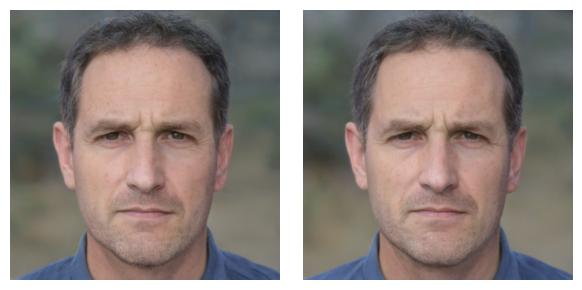

In [6]:
from manipy.stylegan.utils import show_faces
psp_pred = torch.load('/Users/adamsobieszek/Deixis/encoder_preds_step_000000.pt')
psp_pred2 = torch.load('/Users/adamsobieszek/PycharmProjects/_manipy/encoder_preds_best.pt')

# show_faces([psp_pred['latents'][i,0] for i in range(9)], _G=G, rows=3)
new_p2c = {}
new_p2c2 = {}
for j,k in enumerate([f.split('/')[-1] for f in psp_pred['order']]):
    new_p2c[k] = psp_pred['latents'][j]
    new_p2c2[k] = psp_pred2['latents'][j]
    assert new_p2c[k].shape == (512,)


psychGAN_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/"

# torch.save(new_p2c2, psychGAN_path+'newer_photo_to_coords.pt')

# with open(psychGAN_path+"photo_to_coords_psp.pkl", "wb") as f:
#     pickle.dump(new_p2c, f)

show_faces([psp_pred['latents'][0], coords['1.jpg']], _G=G)
# show_faces(torch.load('/Users/adamsobieszek/PycharmProjects/_manipy/combined2/0_m_7.pt')['w'], _G=G)

In [ ]:
from deixis.pixel2style2pixel.criteria.id_loss import IDLoss

idloss = IDLoss(device='mps')
# idloss(psp_pred['latents'][0], coords['1.jpg'])
with torch.no_grad():
    bs = 8
    x = idloss.extract_feats(G.synthesis(psp_pred['latents'][:bs].reshape(bs,1,512).expand(bs,18,-1).to(device), noise_mode='const'))

Loading ResNet ArcFace
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
[[ 0.9245908   0.03928059  0.05440535  0.3577782  -0.0100309   0.18611053
   0.0649285   0.02450982]
 [ 0.10296543  0.8892009   0.17455043  0.20039564  0.0518897   0.10737997
   0.17831966 -0.00408987]
 [ 0.02434642  0.17452797  0.945366    0.20016018  0.33004037  0.15472393
   0.05786783  0.02869684]
 [ 0.23032932  0.16593632  0.2120816   0.9429569   0.12470652  0.22258733
   0.1576184  -0.10656375]
 [-0.05436452  0.02921844  0.24600516  0.0630992   0.9014547   0.25339425
   0.20426041  0.24867085]
 [ 0.19130757  0.09448642  0.10291314  0.21707684  0.24458784  0.83272547
   0.13796517  0.06137916]
 [ 0.03994565  0.13850898  0.09380576  0.20491089  0.25623655  0.11268941
   0.9354081   0.06619824]
 [ 0.04616765  0.01953409  0.02642443 -0.14210767  0.30324003  0.19566476
   0.01211759  0.94665235]]


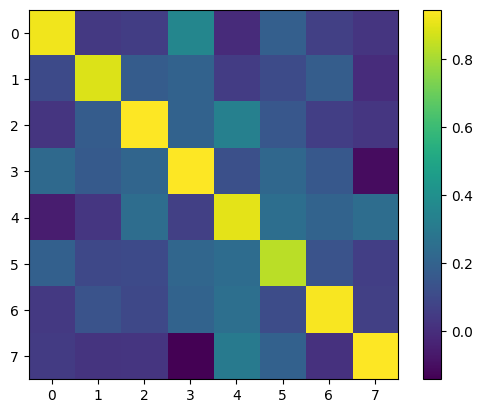

In [27]:
from deixis.pixel2style2pixel.criteria.id_loss import IDLoss

idloss = IDLoss(device='mps')
# idloss(psp_pred['latents'][0], coords['1.jpg'])
with torch.no_grad():
    bs = 8
    x = idloss.extract_feats(G.synthesis(psp_pred['latents'][:bs].reshape(bs,1,512).expand(bs,18,-1).to(device), noise_mode='const'))
    x2 = idloss.extract_feats(G.synthesis((psp_pred['latents'][:bs]+torch.randn_like(psp_pred['latents'][:bs])*0.2).reshape(bs,1,512).expand(bs,18,-1).to(device), noise_mode='const'))
    # heatmap of cosine similarity  
    sim = torch.cosine_similarity(x.unsqueeze(1),x2.unsqueeze(0),dim=2).cpu().numpy()
    print(sim)
    plt.imshow(sim)
    plt.colorbar()
    plt.show()

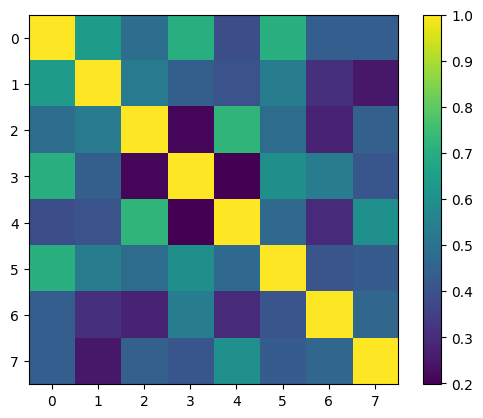

In [23]:
l = (psp_pred['latents'][:bs].to(device) - G.mapping.w_avg.to(device))
# heatmap of cosine similarity
plt.imshow(torch.cosine_similarity(l.unsqueeze(1),l.unsqueeze(0),dim=2).cpu().numpy())
plt.colorbar()
plt.show()

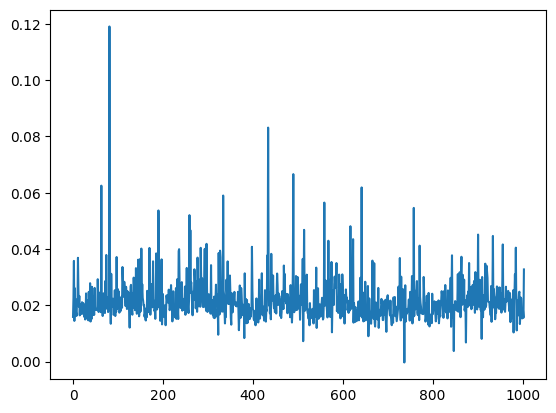

In [8]:
import matplotlib.pyplot as plt
plt.plot(psp_pred['losses']-psp_pred2['losses'])

G_shared shape: torch.Size([1004, 512])
Shared vectors: 1004
Mean L2 distance: 6.2414
Mean cosine similarity: 0.9645
Mean radius difference: -2.6089


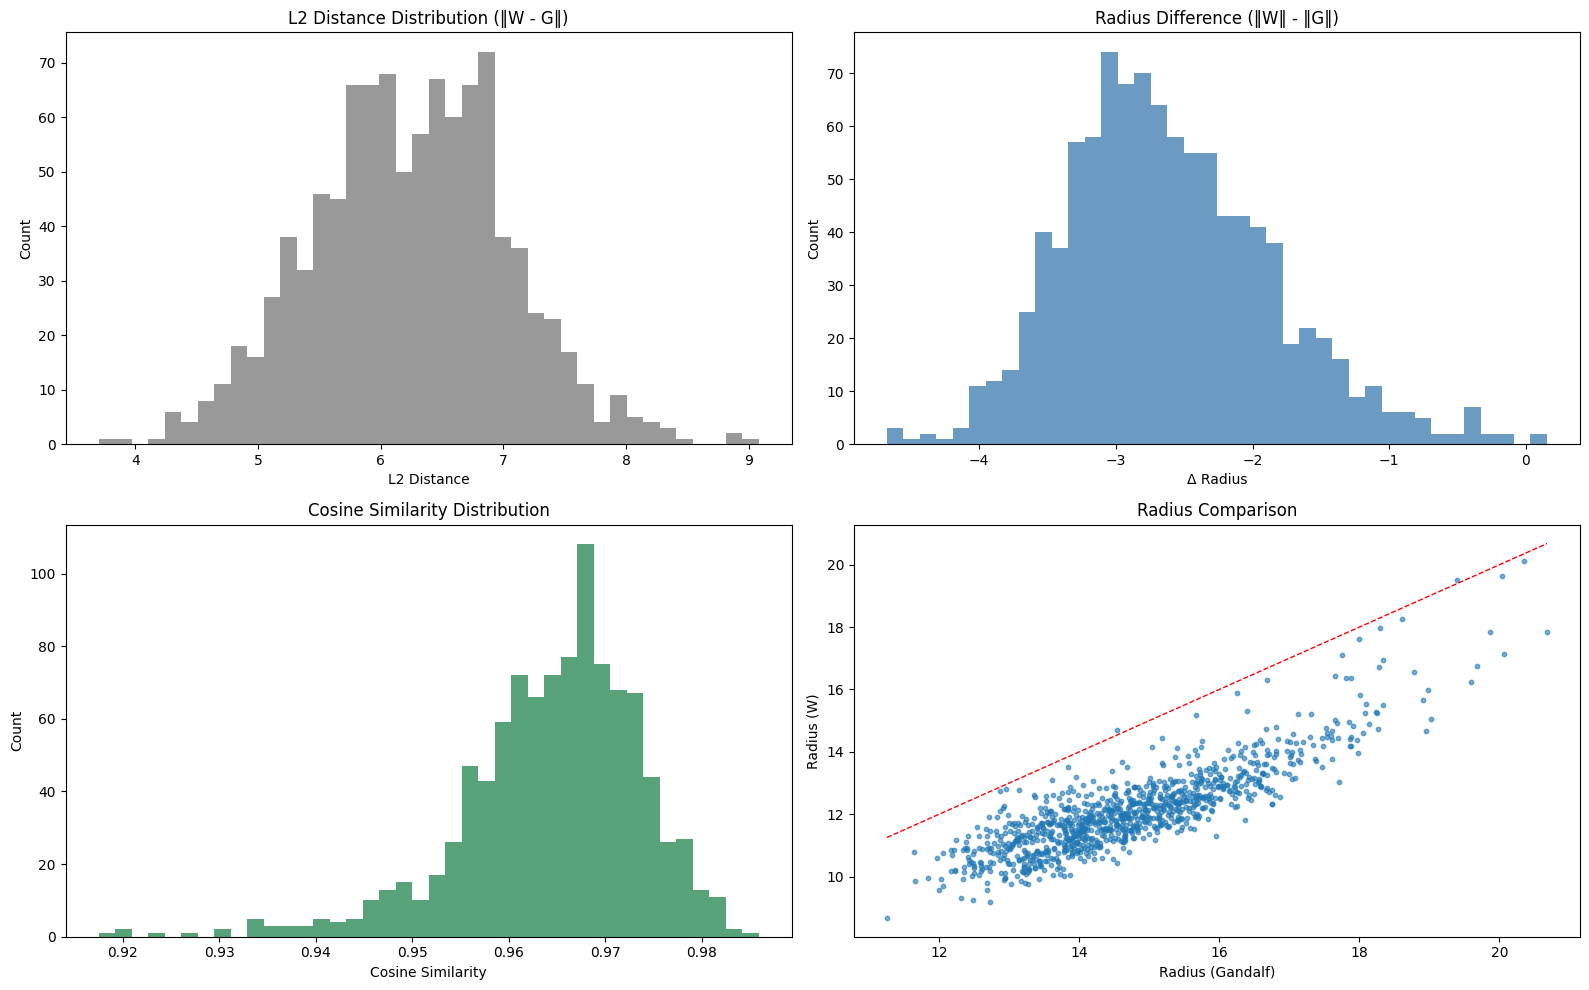

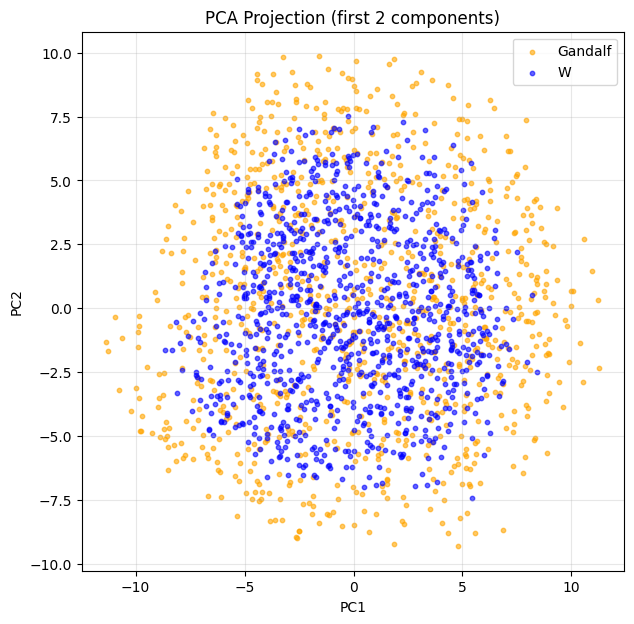

Most similar (min L2): 22.jpg | L2=3.6997 | cos=0.9679
Least similar (max L2): 774.jpg | L2=9.0836 | cos=0.9241


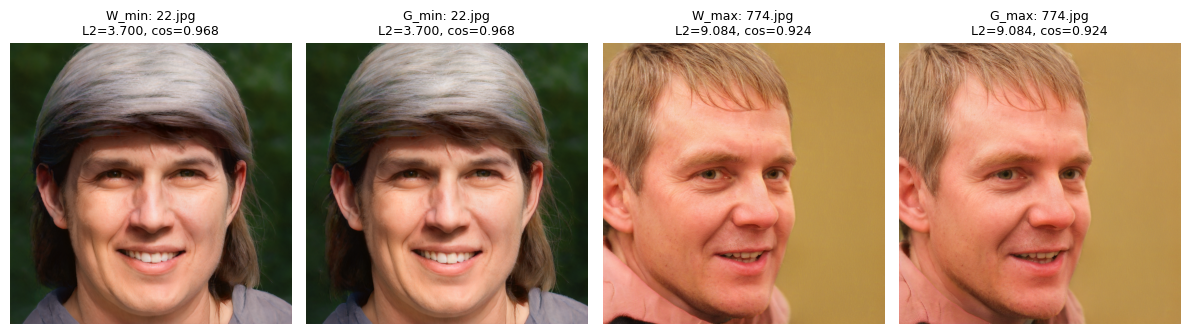

In [9]:
# psychGAN_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/"
# with open(psychGAN_path+"neighbors1.pkl", "wb") as f:
#     pickle.dump(neighbors, f)
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
names_ws = [f.split('/')[-1] for f in psp_pred['order']]
W = psp_pred2['latents']

# IMPORTANT: do NOT use variable name "G" here to avoid colliding with the generator.
gandalf_map = coords

# --- Build dictionaries ---
name_to_w = {n: W[i].view(-1) for i, n in enumerate(names_ws)}

# --- Find shared names ---
shared = sorted(set(name_to_w) & set(gandalf_map))
def to_512_vec(x):
    t = torch.as_tensor(x, dtype=torch.float32)
    if t.ndim == 1:
        if t.numel() != 512:
            raise ValueError(f"Expected 512 dims, got {t.numel()}")
        return t
    # common cases: (1,512), (1,1,512), or similar
    t = t.reshape(-1, 512)
    return t[0]

# --- Extract paired vectors ---
W_shared = torch.stack([name_to_w[n] for n in shared])
G_shared = torch.stack([to_512_vec(gandalf_map[n]) for n in shared])
print("G_shared shape:", G_shared.shape)

# --- Centering ---
mean_w = W_shared.mean(0)
mean_g = G_shared.mean(0)
W_centered = W_shared - mean_w
G_centered = G_shared - mean_g

# --- Compute metrics ---
l2_dists = torch.norm(W_shared - G_shared, dim=1).numpy()
r_w = torch.norm(W_centered, dim=1).numpy()
r_g = torch.norm(G_centered, dim=1).numpy()
radius_diff = r_w - r_g
cos_sim = torch.nn.functional.cosine_similarity(W_centered, G_centered, dim=-1).numpy()

# --- Report basic statistics ---
print(f"Shared vectors: {len(shared)}")
print(f"Mean L2 distance: {l2_dists.mean():.4f}")
print(f"Mean cosine similarity: {cos_sim.mean():.4f}")
print(f"Mean radius difference: {radius_diff.mean():.4f}")

# --- Visualizations ---
plt.figure(figsize=(16, 10))

# 1. L2 distance distribution
plt.subplot(2, 2, 1)
plt.hist(l2_dists, bins=40, color='gray', alpha=0.8)
plt.title("L2 Distance Distribution (‖W - G‖)")
plt.xlabel("L2 Distance")
plt.ylabel("Count")

# 2. Radius difference
plt.subplot(2, 2, 2)
plt.hist(radius_diff, bins=40, color='steelblue', alpha=0.8)
plt.title("Radius Difference (‖W‖ - ‖G‖)")
plt.xlabel("Δ Radius")
plt.ylabel("Count")

# 3. Cosine similarity
plt.subplot(2, 2, 3)
plt.hist(cos_sim, bins=40, color='seagreen', alpha=0.8)
plt.title("Cosine Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")

# 4. Scatter of radii
plt.subplot(2, 2, 4)
plt.scatter(r_g, r_w, s=10, alpha=0.6)
plt.title("Radius Comparison")
plt.xlabel("Radius (Gandalf)")
plt.ylabel("Radius (W)")
plt.plot([r_g.min(), r_g.max()], [r_g.min(), r_g.max()], 'r--', lw=1)

plt.tight_layout()
plt.show()

# --- Additional global structure analysis: PCA projection ---
pca = PCA(n_components=2)
all_concat = torch.cat([W_shared, G_shared], dim=0).numpy()
proj = pca.fit_transform(all_concat)
proj_W, proj_G = proj[:len(shared)], proj[len(shared):]

plt.figure(figsize=(7,7))
plt.scatter(proj_G[:,0], proj_G[:,1], c='orange', label='Gandalf', s=10, alpha=0.6)
plt.scatter(proj_W[:,0], proj_W[:,1], c='blue', label='W', s=10, alpha=0.6)
plt.legend()
plt.title("PCA Projection (first 2 components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()

# =====================================================================
# Generate images for the most similar and least similar pairs
# Assumes a StyleGAN-style generator object named `G` exists in the env.
# =====================================================================

# Find most similar (min L2) and least similar (max L2)
idx_min = int(np.argmin(l2_dists))
idx_max = int(np.argmax(l2_dists))

name_min = shared[idx_min]
name_max = shared[idx_max]

print(f"Most similar (min L2): {name_min} | L2={l2_dists[idx_min]:.4f} | cos={cos_sim[idx_min]:.4f}")
print(f"Least similar (max L2): {name_max} | L2={l2_dists[idx_max]:.4f} | cos={cos_sim[idx_max]:.4f}")

# Build a batch: [W_min, G_min, W_max, G_max]
batch_ws = torch.stack([
    W_shared[idx_min],
    G_shared[idx_min],
    W_shared[idx_max],
    G_shared[idx_max]
], dim=0)  # shape [4, 512]

# Move to the same device as the generator if possible
try:
    gen_device = next(G.parameters()).device  # works if G is nn.Module
except Exception:
    gen_device = torch.device(device)

batch_ws = batch_ws.to(gen_device, dtype=torch.float32)

# Convert to W+ (repeat across layers), commonly 18 for StyleGAN2/FFHQ 1024
B = batch_ws.shape[0]
Wplus = batch_ws.view(B, 1, 512).expand(B, 18, 512).contiguous()

with torch.no_grad():
    imgs = G.synthesis(Wplus, noise_mode='const')  # expected in [-1, 1], shape [B, C, H, W]

# Convert to [0,1] for display
imgs = (imgs.clamp(-1, 1) + 1) / 2  # [B, C, H, W]
imgs = imgs.detach().to('cpu').numpy()

# --- Display the 4 faces ---
titles = [
    f"W_min: {name_min}\nL2={l2_dists[idx_min]:.3f}, cos={cos_sim[idx_min]:.3f}",
    f"G_min: {name_min}\nL2={l2_dists[idx_min]:.3f}, cos={cos_sim[idx_min]:.3f}",
    f"W_max: {name_max}\nL2={l2_dists[idx_max]:.3f}, cos={cos_sim[idx_max]:.3f}",
    f"G_max: {name_max}\nL2={l2_dists[idx_max]:.3f}, cos={cos_sim[idx_max]:.3f}",
]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    # imgs[i] is [C,H,W]; move to [H,W,C]
    img = np.transpose(imgs[i], (1, 2, 0))
    img = np.clip(img, 0.0, 1.0)
    plt.imshow(img)
    plt.axis('off')
    plt.title(titles[i], fontsize=9)
plt.tight_layout()
plt.show()

torch.Size([1004, 1004])
[[   0]
 [   1]
 [   2]
 ...
 [1001]
 [1002]
 [1003]]
tensor([[0.9732],
        [0.9750],
        [0.9704],
        ...,
        [0.9750],
        [0.9754],
        [0.9749]])
tensor([[50.0730],
        [32.0908],
        [31.8758],
        ...,
        [43.3065],
        [42.6688],
        [42.9242]])
0
[[   0]
 [   1]
 [   2]
 ...
 [1001]
 [1002]
 [1003]]
tensor([[0.9732],
        [0.9750],
        [0.9704],
        ...,
        [0.9750],
        [0.9754],
        [0.9749]])
tensor([[7.0762],
        [5.6649],
        [5.6459],
        ...,
        [6.5808],
        [6.5321],
        [6.5517]])


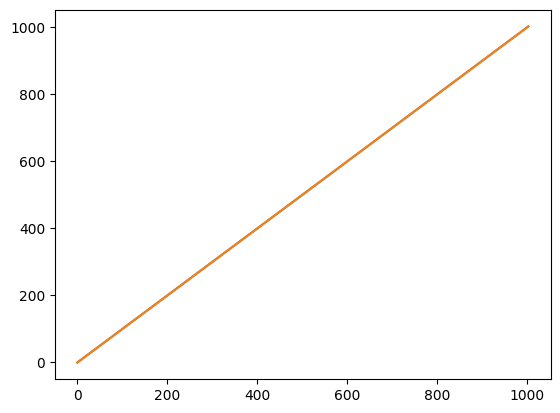

In [10]:
w_avg = G.mapping.w_avg.detach().to(device).cpu()
cos_sim = torch.nn.functional.cosine_similarity(W_shared.unsqueeze(1)-w_avg.reshape(1,1,512), G_shared.unsqueeze(0)-w_avg.reshape(1,1,512), dim=-1)
dist_matrix = torch.norm(W_shared.unsqueeze(1) - G_shared.unsqueeze(0), dim=-1)**2 

# Solve optimal transport problem to uniquely pair each W_shared with a G_shared (minimum cost matching)
from scipy.optimize import linear_sum_assignment

# dist_matrix: [N, N], rows = W_shared, cols = G_shared
row_ind, col_ind = linear_sum_assignment(dist_matrix.cpu().numpy())  # returns index arrays
print(dist_matrix.shape)
# Matching: for each i in W_shared, assign to G_shared[col_ind[i]]
W_matched = W_shared[row_ind]
G_matched = G_shared[col_ind]

# Optionally, also get similarity/cost values for the pairs
matched_cos_sim = cos_sim[row_ind, col_ind]
matched_dist = dist_matrix[row_ind, col_ind]
plt.plot(col_ind)
print(col_ind.reshape(-1,1))
print(matched_cos_sim.reshape(-1,1))
print(matched_dist.reshape(-1,1))
dist_matrix = torch.norm(W_shared.unsqueeze(1) - G_shared.unsqueeze(0), dim=-1)

# Solve optimal transport problem to uniquely pair each W_shared with a G_shared (minimum cost matching)
from scipy.optimize import linear_sum_assignment

# dist_matrix: [N, N], rows = W_shared, cols = G_shared
row_ind2, col_ind2 = linear_sum_assignment(dist_matrix.cpu().numpy())  # returns index arrays
print(sum(col_ind2!=col_ind))

# Optionally, also get similarity/cost values for the pairs
matched_cos_sim = cos_sim[row_ind, col_ind]
matched_dist = dist_matrix[row_ind, col_ind]
plt.plot(col_ind)
print(col_ind.reshape(-1,1))
print(matched_cos_sim.reshape(-1,1))
print(matched_dist.reshape(-1,1))





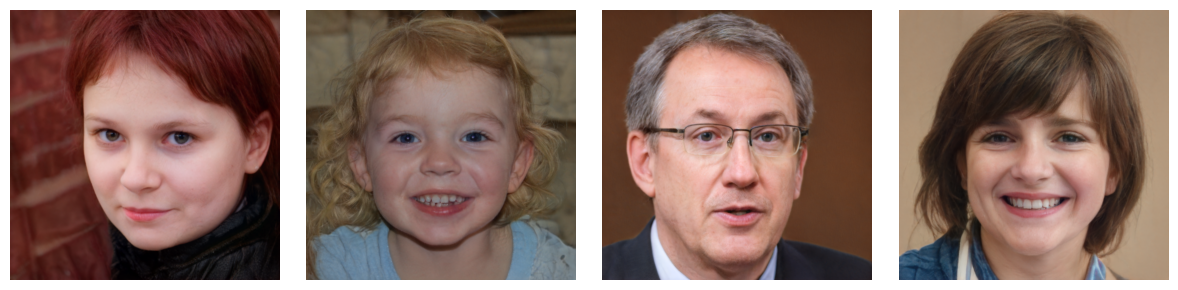

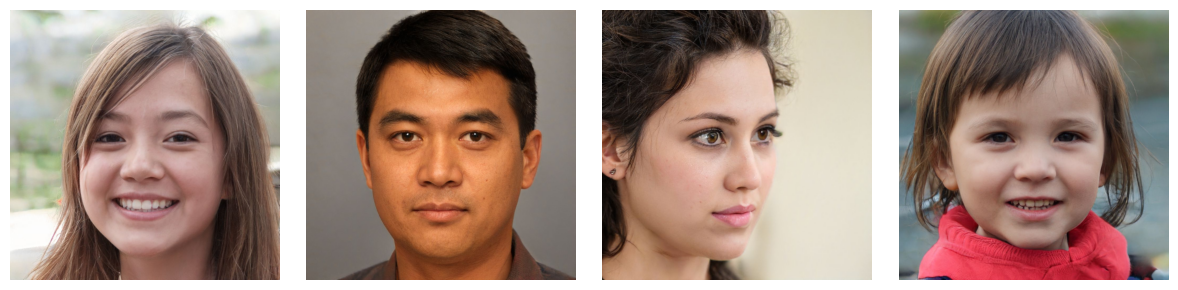

In [11]:
from manipy.stylegan.utils import show_faces
latents = psp_pred['latents']
show_faces(latents[-4:], _G=G)
faces75= sorted(os.listdir("/Users/adamsobieszek/Downloads/0.75"))
faces75= [f for f in faces75 if f.endswith(".jpg") or f.endswith(".png") or f.endswith(".jpeg")]
faces75= [str(os.path.join("/Users/adamsobieszek/Downloads/0.75", f)) for f in [f'{i}.jpg' for i in range(1, 1005)]]
show_faces(faces75[-4:])


In [12]:
import torch
import matplotlib.pyplot as plt

# Assumes: G, CandidateDistribution, coords, device already defined
w_avg = G.mapping.w_avg.detach().to(device)
cosine_threshold = 0.28
n_batches = 100
samples_per_batch = 20_000
with torch.no_grad():
    # Stack latent coords once for batched cosine similarity
    coord_names = []
    centered_units = []
    for name, vec in coords.items():
        centered = vec.to(device) - w_avg
        centered_units.append(centered / centered.norm().clamp_min(1e-9))
        coord_names.append(name)
    coord_matrix = torch.stack(centered_units, dim=0)  # (N, 512)
    coord_names = []
    centered_units = []
    for name, vec in coords.items():
        vec = photo_to_coords[name].to(device)
        centered = vec.to(device) - w_avg
        centered_units.append(centered / centered.norm().clamp_min(1e-9))
        coord_names.append(name)
    coord_matrix2 = torch.stack(centered_units, dim=0)  # (N, 512)

    # Store neighbors as tuple: (samples tensor [N, 512], sims tensor [N])
    # Initialize as empty tensors for each coord name
    # neighbors = {name: (torch.empty((0, 512), device=device), torch.empty((0,), device=device)) for name in coord_names}
    max_neighbors = 2048

    for batch_idx in range(n_batches):
        z_batch = torch.randn(samples_per_batch, G.z_dim, device=device)

        w_batch = G.mapping(z_batch, None)
        samples_centered = w_batch - w_avg
        samples_unit = samples_centered / samples_centered.norm(dim=1, keepdim=True).clamp_min(1e-9)  # (M, 512)
        
        sims = coord_matrix @ samples_unit.T  # (N, M)
        sims2 = coord_matrix2 @ samples_unit.T  # (N, M)
        sims = torch.stack([sims, sims2])
        sims = torch.max(sims, dim=0)[0]
        mask = sims >= cosine_threshold

        for row, name in enumerate(coord_names):
            idxs = torch.nonzero(mask[row], as_tuple=False).view(-1)
            if idxs.numel():
                selected_w_samples = w_batch[idxs].to(device)  # [num_sel, 512]
                selected_z_samples = z_batch[idxs].to(device)  # [num_sel, z_dim]
                selected_sims = sims[row, idxs]  # [num_sel]

                if name in neighbors and len(neighbors[name]) == 3:
                    prev_w_samples, prev_sims, prev_z_samples = neighbors[name]
                else:
                    prev_w_samples = torch.empty((0, w_batch.shape[1]), device=device)
                    prev_z_samples = torch.empty((0, z_batch.shape[1]), device=device)
                    prev_sims = torch.empty((0,), device=device)

                if prev_w_samples.shape[0] < max_neighbors:
                    # Not enough, just concatenate (but do not exceed max_neighbors)
                    need = max_neighbors - prev_w_samples.shape[0]
                    append_w = selected_w_samples[:need]
                    append_z = selected_z_samples[:need]
                    append_sims = selected_sims[:need]
                    new_w_samples = torch.cat([prev_w_samples, append_w], dim=0)
                    new_z_samples = torch.cat([prev_z_samples, append_z], dim=0)
                    new_sims = torch.cat([prev_sims, append_sims], dim=0)
                    neighbors[name] = (new_w_samples, new_sims, new_z_samples)
                else:
                    # Already at max_neighbors: keep only top values by similarity
                    combined_w = torch.cat([prev_w_samples, selected_w_samples], dim=0)
                    combined_z = torch.cat([prev_z_samples, selected_z_samples], dim=0)
                    combined_sims = torch.cat([prev_sims, selected_sims], dim=0)
                    # Get top max_neighbors by sim
                    topk_sims, topk_idx = torch.topk(combined_sims, max_neighbors)
                    topk_w_samples = combined_w[topk_idx]
                    topk_z_samples = combined_z[topk_idx]
                    neighbors[name] = (topk_w_samples, topk_sims, topk_z_samples)


        counts = [torch.mean(v[1]).item() for v in neighbors.values()]
        plt.figure(figsize=(8, 4))
        plt.hist(counts, bins=40)
        plt.xlabel("Number of neighbors found (per image)")
        plt.ylabel("Count")
        plt.title(f"Neighbor count per image up to batch {batch_idx + 1}")
        plt.show()


/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_39748/3551364226.py:39: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4419.)
  sims = coord_matrix @ samples_unit.T  # (N, M)


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [512, 512] but got: [512, 18].

In [ ]:
neighbors['1.jpg']

[(5586, 0.2981533706188202),
 (14825, 0.28092360496520996),
 (624, 0.28153127431869507),
 (8120, 0.3000640869140625),
 (7000, 0.280342698097229),
 (12494, 0.29322272539138794),
 (1849, 0.2805165946483612),
 (4134, 0.2891872227191925),
 (4151, 0.28222212195396423),
 (5293, 0.2819307744503021),
 (5581, 0.3037855923175812),
 (16538, 0.2840842604637146),
 (4691, 0.29730015993118286),
 (18541, 0.30214980244636536),
 (338, 0.2817513346672058),
 (3490, 0.3117392361164093),
 (17095, 0.29760637879371643),
 (19976, 0.2973032593727112),
 (7137, 0.30002668499946594),
 (1207, 0.29836633801460266),
 (6081, 0.3042919337749481),
 (8464, 0.2905455231666565),
 (5791, 0.2829233407974243),
 (9595, 0.2890264093875885),
 (13446, 0.30201274156570435),
 (19003, 0.2833862602710724),
 (214, 0.296224445104599),
 (1820, 0.29404395818710327),
 (4887, 0.29065775871276855),
 (16562, 0.29559624195098877),
 (1140, 0.28154414892196655),
 (2908, 0.2805529236793518),
 (12410, 0.28688737750053406),
 (1121, 0.2947036623954

In [ ]:
best_coords = {}

with torch.no_grad():
    # Stack latent coords once for batched cosine similarity

        for row, name in enumerate(coord_names):

            samples_centered = neighbors[name][1]
            samples_unit = samples_centered / samples_centered.norm(dim=1, keepdim=True).clamp_min(1e-9)  # (M, 512)

            sims = coord_matrix @ samples_unit.T  # (N, M)
            mask = sims >= cosine_threshold
            idxs = torch.nonzero(mask[row], as_tuple=False).view(-1)
            if idxs.numel():
                neighbors[name].extend(
                    (int(i.item()), float(sims[row, i].item()))
                    for i in idxs
                )

        counts = [len(v) for v in neighbors.values()]
        plt.figure(figsize=(8, 4))
        plt.hist(counts, bins=40)
        plt.xlabel("Number of neighbors found (per image)")
        plt.ylabel("Count")
        plt.title(f"Neighbor count per image up to batch {batch_idx + 1}")
        plt.show()

best_coords

In [ ]:
OUTPUT_DIR = FOLDER / 'refined_latents2'

results = projector.refine_folder(
    FOLDER,
    photo_to_latent=coords,
    photo_to_covariance=covs,
    output_dir=OUTPUT_DIR,
    overwrite=False,
)

print(f'Refined {len(results)} faces. Saved tensors to {OUTPUT_DIR}')

In [ ]:
if results:
    summary = {
        name: {
            'loss_start': float(outcome.loss_history[0].item()),
            'loss_final': float(outcome.loss_history[-1].item()),
            'steps': len(outcome.loss_history),
        }
        for name, outcome in results.items()
    }
    list(summary.items())[:5]
else:
    print('No faces refined; check priors or folder path.')

No faces refined; check priors or folder path.
